In [1]:
import glob
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

class ISO:
    
    """
    
    Reads in MIST isochrone files.
    
    """
    
    def __init__(self, filename, verbose=True):
    
        """
        
        Args:
            filename: the name of .iso file.
        
        Usage:
            >> iso = read_mist_models.ISO('MIST_v1.0_feh_p0.00_afe_p0.0_vvcrit0.4.iso')
            >> age_ind = iso.age_index(8.0)
            >> logTeff = iso.isos[age_ind]['log_Teff']
            >> logL = iso.isos[age_ind]['log_L']
            >> plt.plot(logTeff, logL) #plot the HR diagram for logage = 8.0
            
        Attributes:
            version     Dictionary containing the MIST and MESA version numbers.
            abun        Dictionary containing Yinit, Zinit, [Fe/H], and [a/Fe] values.
            rot         Rotation in units of surface v/v_crit.
            ages        List of ages.
            num_ages    Number of isochrones.
            hdr_list    List of column headers.
            isos        Data.
            
        """
        
        self.filename = filename
        if verbose:
            print('Reading in: ' + self.filename)
            
        self.version, self.abun, self.rot, self.ages, self.num_ages, self.hdr_list, self.isos = self.read_iso_file()
        
    def read_iso_file(self):

        """
        Reads in the isochrone file.
        
        Args:
            filename: the name of .iso file.
        
        """
        
        #open file and read it in
        with open(self.filename) as f:
            content = [line.split() for line in f]
        version = {'MIST': content[0][-1], 'MESA': content[1][-1]}
        abun = {content[3][i]:float(content[4][i]) for i in range(1,5)}
        rot = float(content[4][-1])
        num_ages = int(content[6][-1])
        
        #read one block for each isochrone
        iso_set = []
        ages = []
        counter = 0
        data = content[8:]
        for i_age in range(num_ages):
            #grab info for each isochrone
            num_eeps = int(data[counter][-2])
            num_cols = int(data[counter][-1])
            hdr_list = data[counter+2][1:]
            formats = tuple([np.int32]+[np.float64 for i in range(num_cols-1)])
            iso = np.zeros((num_eeps),{'names':tuple(hdr_list),'formats':tuple(formats)})
            #read through EEPs for each isochrone
            for eep in range(num_eeps):
                iso_chunk = data[3+counter+eep]
                iso[eep]=tuple(iso_chunk)
            iso_set.append(iso)
            ages.append(iso[0][1])
            counter+= 3+num_eeps+2
        return version, abun, rot, ages, num_ages, hdr_list, iso_set  
        
    def age_index(self, age):
    
        """
        Returns the index for the user-specified age.
    
        Args:
            age: the age of the isochrone.
    
        """
    
        diff_arr = abs(np.array(self.ages) - age)
        age_index = np.where(diff_arr == min(diff_arr))[0][0]
    
        if ((age > max(self.ages)) | (age < min(self.ages))):
            print('The requested age is outside the range. Try between ' + str(min(self.ages)) + ' and ' + str(max(self.ages)))
        
        return age_index
    		
class ISOCMD:
    
    """
    
    Reads in MIST CMD files.
    
    """
    
    def __init__(self, filename, verbose=True):
    
        """
        
        Args:
            filename: the name of .iso.cmd file.
        
        Usage:
            >> isocmd = read_mist_models.ISOCMD('MIST_v1.0_feh_p0.00_afe_p0.0_vvcrit0.4.iso.cmd')
            >> age_ind = isocmd.age_index(7.0)
            >> B = isocmd.isocmds[age_ind]['Bessell_B']
            >> V = isocmd.isocmds[age_ind]['Bessell_V']
            >> plt.plot(B-V, V) #plot the CMD for logage = 7.0
        
        Attributes:
            version         Dictionary containing the MIST and MESA version numbers.
            photo_sys       Photometric system. 
            abun            Dictionary containing Yinit, Zinit, [Fe/H], and [a/Fe] values.
            Av_extinction   Av for CCM89 extinction.
            rot             Rotation in units of surface v/v_crit.
            ages            List of ages.
            num_ages        Number of ages.
            hdr_list        List of column headers.
            isocmds         Data.
        
        """
        
        self.filename = filename
        if verbose:
            print('Reading in: ' + self.filename)
            
        self.version, self.photo_sys, self.abun, self.Av_extinction, self.rot, self.ages, self.num_ages, self.hdr_list, self.isocmds = self.read_isocmd_file()
    
    def read_isocmd_file(self):

        """
        Reads in the cmd file.
        
        Args:
            filename: the name of .iso.cmd file.
        
        """
        
        #open file and read it in
        with open(self.filename) as f:
            content = [line.split() for line in f]
        version = {'MIST': content[0][-1], 'MESA': content[1][-1]}
        photo_sys = ' '.join(content[2][4:])
        abun = {content[4][i]:float(content[5][i]) for i in range(1,5)}
        rot = float(content[5][-1])
        num_ages = int(content[7][-1])
        Av_extinction = float(content[8][-1])
        
        #read one block for each isochrone
        isocmd_set = []
        ages = []
        counter = 0
        data = content[10:]
        for i_age in range(num_ages):
            #grab info for each isochrone
            num_eeps = int(data[counter][-2])
            num_cols = int(data[counter][-1])
            hdr_list = data[counter+2][1:]
            formats = tuple([np.int32]+[np.float64 for i in range(num_cols-1)])
            isocmd = np.zeros((num_eeps),{'names':tuple(hdr_list),'formats':tuple(formats)})
            #read through EEPs for each isochrone
            for eep in range(num_eeps):
                isocmd_chunk = data[3+counter+eep]
                isocmd[eep]=tuple(isocmd_chunk)
            isocmd_set.append(isocmd)
            ages.append(isocmd[0][1])
            counter+= 3+num_eeps+2
        return version, photo_sys, abun, Av_extinction, rot, ages, num_ages, hdr_list, isocmd_set

    def age_index(self, age):
        
        """
        Returns the index for the user-specified age.
        
        Args:
            age: the age of the isochrone.
        
        """
        
        diff_arr = abs(np.array(self.ages) - age)
        age_index = np.where(diff_arr == min(diff_arr))[0][0]
        
        if ((age > max(self.ages)) | (age < min(self.ages))):
            print('The requested age is outside the range. Try between ' + str(min(self.ages)) + ' and ' + str(max(self.ages)))
            
        return age_index

        
class EEP:
    
    """
    
    Reads in and plots MESA EEP files.
    
    """
    
    def __init__(self, filename, verbose=True):
        
        """
        
        Args:
            filename: the name of .track.eep file.
        
        Usage:
            >> eep = read_mist_models.EEP('00200M.track.eep')
            >> logTeff, center_h1, mdot = eep.eeps['log_Teff'], eep['center_h1'], eep['star_mdot']
            
        Attributes:
            version         Dictionary containing the MIST and MESA version numbers.
            abun            Dictionary containing Yinit, Zinit, [Fe/H], and [a/Fe] values.
            rot             Rotation in units of surface v/v_crit.
            minit           Initial mass in solar masses.
            hdr_list        List of column headers.
            eeps            Data.
            
        """
                        
        self.filename = filename
        if verbose:
            print('Reading in: ' + self.filename)
                        
        self.version, self.abun, self.rot, self.minit, self.hdr_list, self.eeps = self.read_eep_file()
        
    def read_eep_file(self):
        
        """
        Reads in the EEP file.
        
        Args:
            filename: the name of .track.eep file.
                
        """
        
        eeps = np.genfromtxt(self.filename, skip_header=11, names=True)
        
        with open(self.filename) as f:
            content = [line.split() for line in f]

        version = {'MIST': content[0][-1], 'MESA': content[1][-1]}
        abun = {content[3][i]:float(content[4][i]) for i in range(1,5)}
        rot = float(content[4][-1])
        minit = float(content[7][1])
        hdr_list = content[11][1:]
        
        return version, abun, rot, minit, hdr_list, eeps
        		
    def plot_HR(self, fignum=0, phases=[], phasecolor=[], **kwargs):
        
        """
        Plots the HR diagram.
        Args:
            None.
            
        Keywords:
            accepts matplotlib keywords: color, linestyle, linewidth, etc.
            keyword: fignum, phase*, phasecolor
            
            * Following the FSPS notation,
            * PMS:-1 ; MS:0 ; SGB+RGB:2 ; CHeB:3 ; EAGB:4 ; TPAGB:5 ; post-AGB:6 ; WR:9
    
        Usage:
            >> eep.plot_HR(fignum=3)
            >> eep.plot_HR(phase=[0, 2], phasecolor=['Gray', 'Blue']) #highlight the MS and RGB phases in gray and blue.
        
        """
        
        x = self.eeps['log_Teff']
        y = self.eeps['log_L']
        
        fig = plt.figure(fignum)
        plt.xlabel('log(Teff) [K]', fontsize=22)
        plt.ylabel('log(L/Lsun)', fontsize=22)
        
        ax = fig.add_subplot(111)
        ax.plot(x, y, **kwargs)
        ax.axis([max(x)+0.2, min(x)-0.2, min(y)-0.2, max(y)+0.2])

        if len(phases) >= 0:
            if len(phases) != len(phasecolor):
                print('The length of the phase and phasecolor array must be identical.')
                return
            for i_p, phase in enumerate(phases):
                p = self.eeps['phase']
                p_ind = np.where(p == phase)
                if len(p_ind) > 0:
                    if phasecolor == '':
                        ax.plot(x[p_ind], y[p_ind], linewidth=4.0, alpha=0.5)
                    else:
                        ax.plot(x[p_ind], y[p_ind], color=phasecolor[i_p], linewidth=4.0, alpha=0.5)

class EEPCMD:
    
    """
    
    Reads in and plots MESA EEP CMD files.
    
    """
    
    def __init__(self, filename, verbose=True):
        
        """
        
        Args:
            filename: the name of .track.eep.cmd file.
        
        Usage:
            >> eepcmd = read_mist_models.EEPCMD('00200M.track.eep.cmd')
            >> B, V, mdot = eepcmd.eepcmds['Bessell_B'], eep['Bessell_V'], eep['star_mdot']
            
        Attributes:
            version         Dictionary containing the MIST and MESA version numbers.
            photo_sys       Photometric system.
            abun            Dictionary containing Yinit, Zinit, [Fe/H], and [a/Fe] values.
            rot             Rotation in units of surface v/v_crit.
            minit           Initial mass in solar masses.
            hdr_list        List of column headers.
            Av_extinction   Av for CCM89 extinction.
            eepcmds         Data.
            
        """
                        
        self.filename = filename
        if verbose:
            print('Reading in: ' + self.filename)
                        
        self.version, self.photo_sys, self.abun, self.rot, self.minit, self.Av_extinction, self.hdr_list, self.eepcmds = self.read_eepcmd_file()
        
    def read_eepcmd_file(self):
        
        """
        Reads in the EEP CMD file.
        
        Args:
            filename: the name of .eep.cmd file.
                
        """
        
        eepcmds = np.genfromtxt(self.filename, skip_header=14, names=True)
        
        with open(self.filename) as f:
            content = [line.split() for line in f]

        version = {'MIST': content[0][-1], 'MESA': content[1][-1]}
        photo_sys = ' '.join(content[2][4:])
        abun = {content[4][i]:float(content[5][i]) for i in range(1,5)}
        rot = float(content[5][-1])
        minit = float(content[8][1])
        Av_extinction = float(content[11][-1])
        hdr_list = content[14][1:]
        
        return version, photo_sys, abun, rot, minit, Av_extinction, hdr_list, eepcmds
        		
    def plot_CMD(self, filters, fignum=0, phases=[], phasecolor=[], **kwargs):
        
        """
        Plots the CMD diagram.
        Args:
            filters: a list of three filters, ['filter1', 'filter2', 'filter3']. x-axis: 'filter1'-'filter2', y-axis: 'filter3'
            
        Keywords:
            accepts matplotlib keywords: color, linestyle, linewidth, etc.
            keyword: fignum, phase*, phasecolor
            
            * Following the FSPS notation,
            * PMS:-1 ; MS:0 ; SGB+RGB:2 ; CHeB:3 ; EAGB:4 ; TPAGB:5 ; post-AGB:6 ; WR:9
    
        Usage:
            >> eepcmd.plot_CMD(['Bessell_B', 'Bessell_V', 'Bessell_V'], fignum=3)
        """
        
        try:
            x1 = self.eepcmds[filters[0]]
        except:
            print(filters[0]) + ' does not appear in this file.'
            return
        try:
            x2 = self.eepcmds[filters[1]]
        except:
            print(filters[1]) + ' does not appear in this file.'
            return
        try:
            y = self.eepcmds[filters[2]]
        except:
            print(filters[2]) + ' does not appear in this file.'
            return
        
        fig = plt.figure(fignum)
        plt.xlabel(' '.join(filters[0].split('_')) + '-' + ' '.join(filters[1].split('_')), fontsize=22)
        plt.ylabel(' '.join(filters[2].split('_')), fontsize=22)
        
        ax = fig.add_subplot(111)
        ax.plot(x1-x2, y, **kwargs)
        ax.axis([min(x1-x2)-0.2, max(x1-x2)+0.2, max(y)+0.2, min(y)-0.2])

        if len(phases) >= 0:
            if len(phases) != len(phasecolor):
                print('The length of the phase and phasecolor array must be identical.')
                return
            for i_p, phase in enumerate(phases):
                p = self.eepcmds['phase']
                p_ind = np.where(p == phase)
                if len(p_ind) > 0:
                    if phasecolor == '':
                        ax.plot(x1[p_ind]-x2[p_ind], y[p_ind], linewidth=4.0, alpha=0.5)
                    else:
                        ax.plot(x1[p_ind]-x2[p_ind], y[p_ind], color=phasecolor[i_p], linewidth=4.0, alpha=0.5)

        

In [2]:
import read_mist_models
def plot_iso(gridname):
    
    """
    
    Generates .pdf files of isochrones.
    
    Args:
        gridname: the name of the grid
    Keywords:
        None
    Returns:
        None
        
    """
    #Assumes gridname has the form MIST_vXX/feh_XXX_afe_XXX
    isochrone = read_mist_models.ISO('isochrones_example.txt')
    
    age_list = np.linspace(5, 10.3, 107)
    for i_a, age in enumerate(age_list):
        plt.plot(isochrone.isos[i_a]['log_Teff'], isochrone.isos[i_a]['log_L'], fig_num=1)
        
        if age <= 7.0:
            plt.axis([5.5, 3.2, -3, 7])
        elif ((age > 7.0) & (age <= 9.0)):
            plt.axis([6.0, 2.5, -6, 6])
        elif age > 9.0:
            plt.axis([5.5, 2.0, -8, 4])
            
        plt.title(str(age))
        plt.clf()

Reading in: isochrones_example.txt


AttributeError: 'Line2D' object has no property 'fig_num'

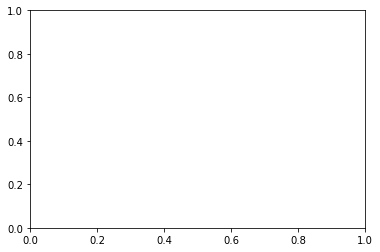

In [20]:
plot_iso(' ')

In [4]:
    def read_iso_file(file):

        """

        Reads in the isochrone file.
        
        Args:
            filename: the name of .iso file.
        
        """
        
        #open file and read it in
        with open(file) as f:
            content = [line.split() for line in f]
        version = {'MIST': content[0][-1], 'MESA': content[1][-1]}
        abun = {content[3][i]:float(content[4][i]) for i in range(1,5)}
        rot = float(content[4][-1])
        num_ages = int(content[6][-1])
        
        #read one block for each isochrone
        iso_set = []
        ages = []
        counter = 0
        data = content[8:]
        for i_age in range(num_ages):
            #grab info for each isochrone
            num_eeps = int(data[counter][-2])
            num_cols = int(data[counter][-1])
            hdr_list = data[counter+2][1:]
            formats = tuple([np.int32]+[np.float64 for i in range(num_cols-1)])
            iso = np.zeros((num_eeps),{'names':tuple(hdr_list),'formats':tuple(formats)})
            #read through EEPs for each isochrone
            for eep in range(num_eeps):
                iso_chunk = data[3+counter+eep]
                iso[eep]=tuple(iso_chunk)
            iso_set.append(iso)
            ages.append(iso[0][1])
            counter+= 3+num_eeps+2
        return version, abun, rot, ages, num_ages, hdr_list, iso_set

In [5]:
version, abun, rot, ages, num_ages, hdr_list, iso_set = read_iso_file('isochrones_example.txt')

In [6]:
iso_set[0]

array([(35, 5., 0.53636124, 0.53636124, 0., 0., 0., 0.60659223, -10.        , -10., 3.66070247, 0.50515127, 3.15531283, 0.751106, 3.e-05, 0.247004, 0.0003252, 0.0008846, 6.10815208, -0.82395413, 0., 0.751106, 0.247004, 0.0003252, -1.),
       (36, 5., 0.59190064, 0.59190064, 0., 0., 0., 0.67650951, -10.        , -10., 3.66853415, 0.52444655, 3.16069905, 0.751106, 3.e-05, 0.247004, 0.0003252, 0.0008846, 6.13161473, -0.83976841, 0., 0.751106, 0.247004, 0.0003252, -1.),
       (37, 5., 0.65275   , 0.65275   , 0., 0., 0., 0.74174649, -10.        , -10., 3.67534748, 0.54343838, 3.164443  , 0.751106, 3.e-05, 0.247004, 0.0003252, 0.0008846, 6.15328042, -0.85671997, 0., 0.751106, 0.247004, 0.0003252, -1.),
       (38, 5., 0.71464924, 0.71464924, 0., 0., 0., 0.80480598, -10.        , -10., 3.68174421, 0.56217468, 3.16709815, 0.751106, 3.e-05, 0.247004, 0.0003252, 0.0008846, 6.17414315, -0.8727658 , 0., 0.751106, 0.247004, 0.0003252, -1.),
       (39, 5., 0.78362892, 0.78362892, 0., 0., 0., 0.86

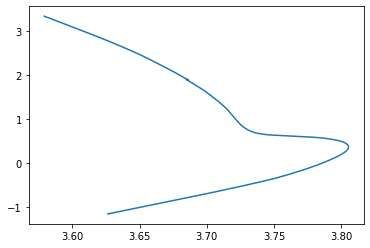

In [8]:
df = pd.DataFrame(iso_set[-1],columns = hdr_list)
plt.plot(df['log_Teff'],df['log_L'])

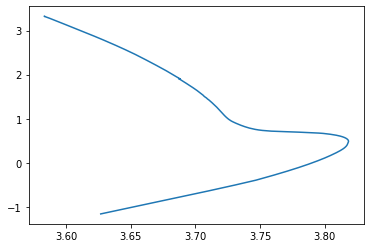

In [9]:
df = pd.DataFrame(iso_set[-2],columns = hdr_list)
plt.plot(df['log_Teff'],df['log_L'])

In [58]:
hdr_list

['EEP',
 'log10_isochrone_age_yr',
 'initial_mass',
 'star_mass',
 'star_mdot',
 'he_core_mass',
 'c_core_mass',
 'log_L',
 'log_LH',
 'log_LHe',
 'log_Teff',
 'log_R',
 'log_g',
 'surface_h1',
 'surface_he3',
 'surface_he4',
 'surface_c12',
 'surface_o16',
 'log_center_T',
 'log_center_Rho',
 'center_gamma',
 'center_h1',
 'center_he4',
 'center_c12',
 'phase']

IndexError: index 0 is out of bounds for axis 0 with size 0

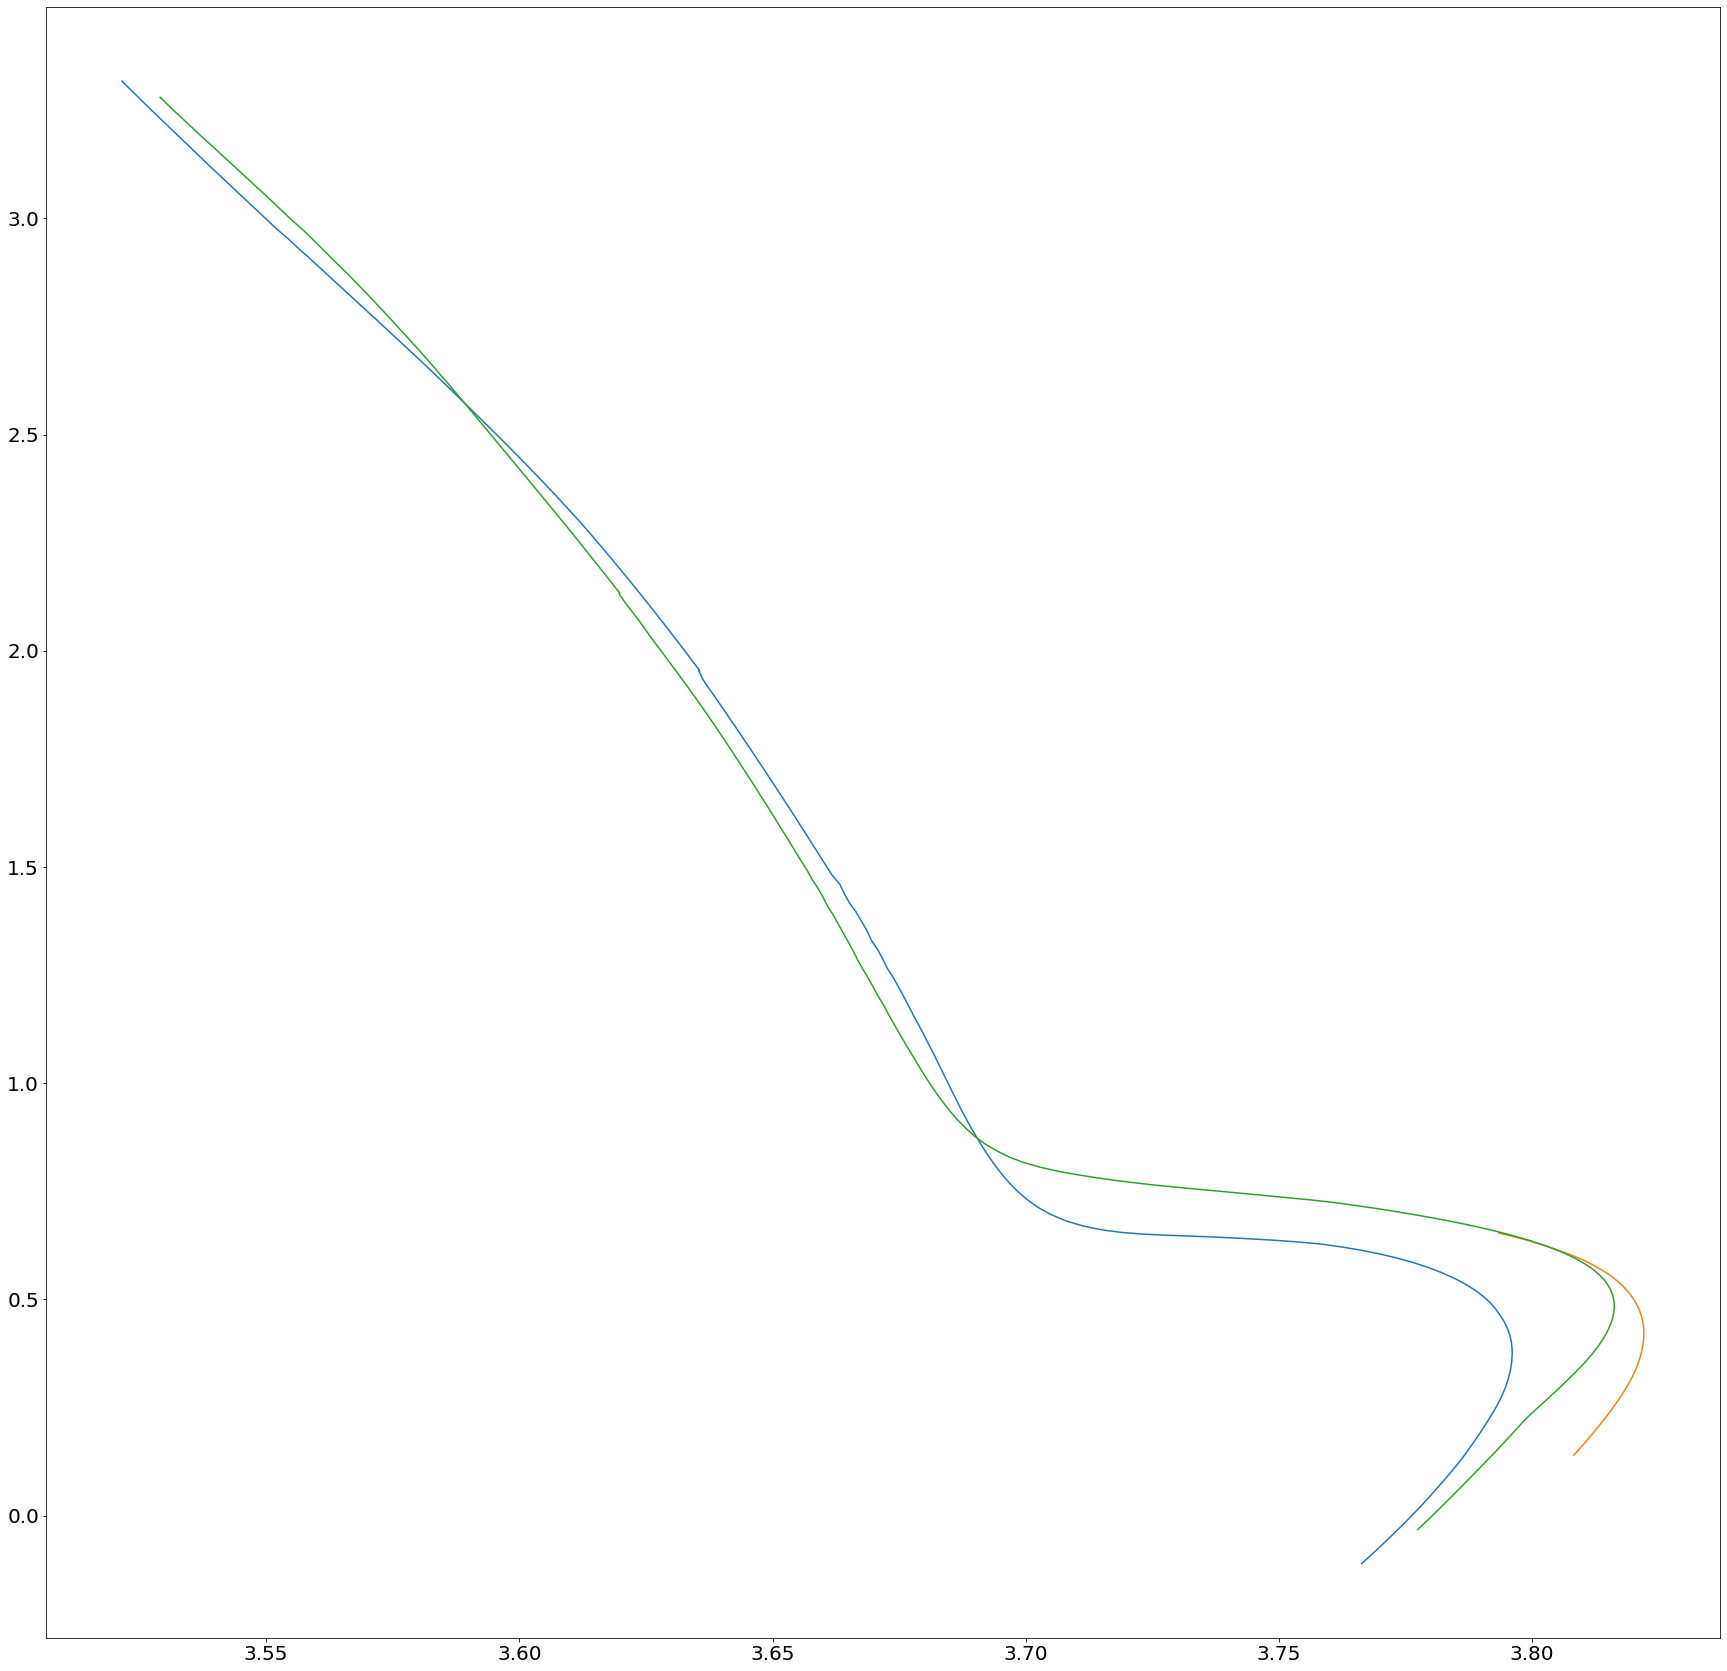

In [114]:
os.chdir('/home/zookeeper/Desktop/workdir/9.6/outiso')
for file in os.listdir():
    version, abun, rot, ages, num_ages, hdr_list, iso_set = read_iso_file(file)
    df = pd.DataFrame(iso_set[-1],columns = hdr_list)
    plt.plot(df['log_Teff'],df['log_L'])

In [9]:
ages

[5.0,
 5.1,
 5.2,
 5.3,
 5.4,
 5.5,
 5.6,
 5.7,
 5.8,
 5.9,
 6.0,
 6.1,
 6.2,
 6.3,
 6.4,
 6.5,
 6.6,
 6.7,
 6.8,
 6.9,
 7.0,
 7.1,
 7.2,
 7.300000000000001,
 7.4,
 7.5,
 7.6,
 7.7,
 7.800000000000001,
 7.9,
 8.0,
 8.1,
 8.2,
 8.3,
 8.4,
 8.5,
 8.6,
 8.7,
 8.8,
 8.9,
 9.0,
 9.100000000000001,
 9.2,
 9.3,
 9.4,
 9.5,
 9.600000000000001,
 9.7,
 9.8,
 9.9,
 10.0]

In [11]:
os.listdir()

['isochrones_1853.txt',
 'isochrones_1059.txt',
 'isochrones_1243.txt',
 'isochrones_1084.txt',
 'isochrones_1234.txt',
 'isochrones_1458.txt',
 'isochrones_1057.txt',
 'isochrones_1417.txt',
 'isochrones_1334.txt',
 'isochrones_1153.txt',
 'isochrones_1547.txt',
 'isochrones_1624.txt',
 'isochrones_1189.txt',
 'isochrones_1482.txt',
 'isochrones_1206.txt',
 'isochrones_1550.txt',
 'isochrones_1660.txt',
 'isochrones_1820.txt',
 'isochrones_1053.txt',
 'isochrones_1527.txt']

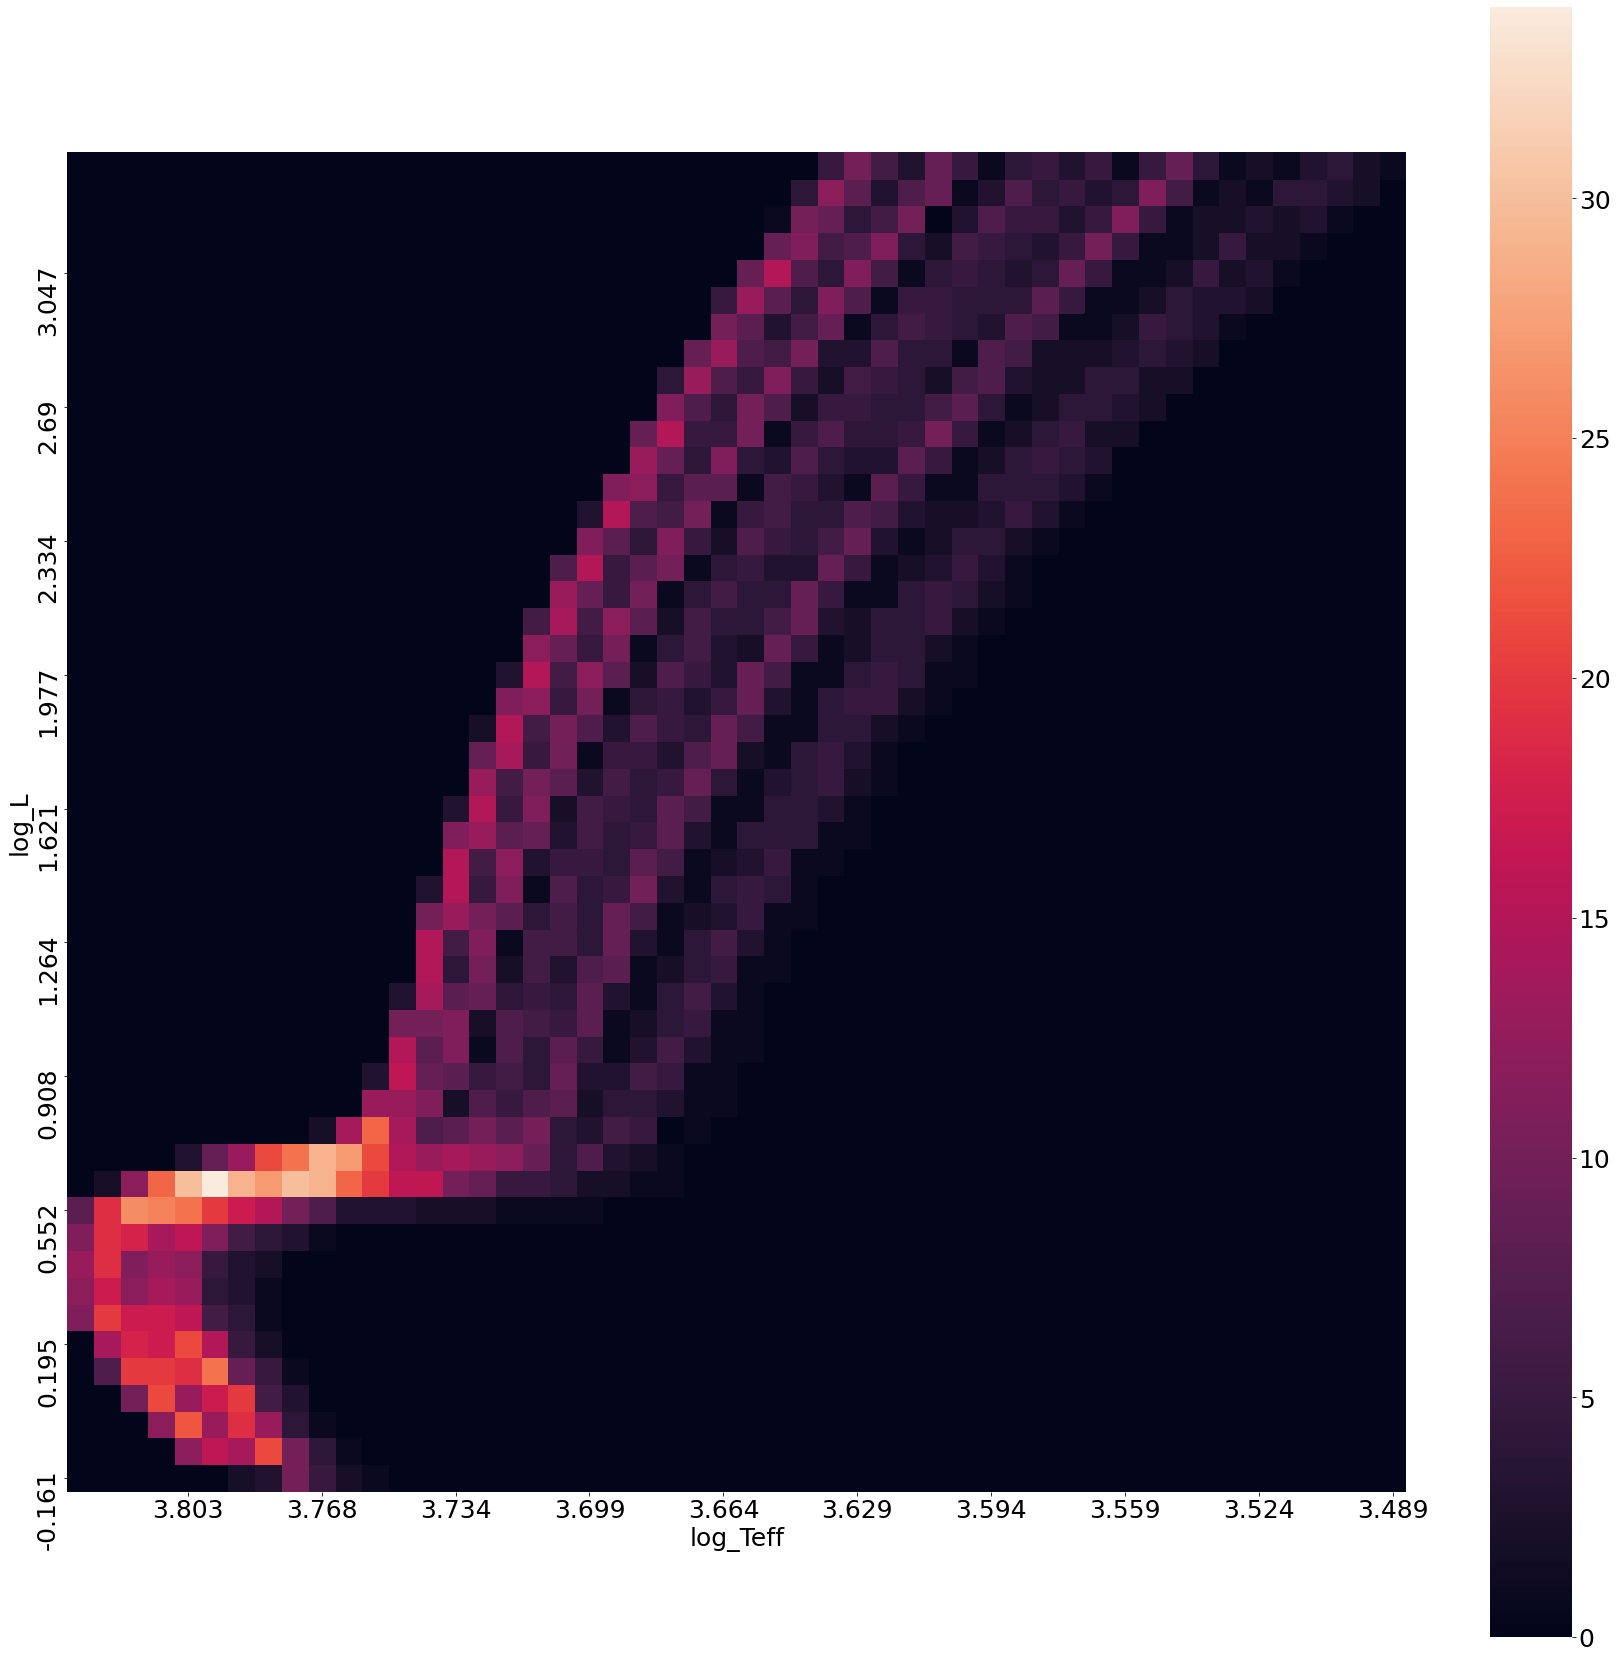

In [120]:
plt.matplotlib.rcParams['figure.figsize'] = (30,30)
plt.matplotlib.rcParams['font.size'] = 25

os.chdir('/home/zookeeper/Desktop/workdir/9.6/outiso')
x = np.array([])
y = np.array([])
for file in os.listdir():
    try:
        version, abun, rot, ages, num_ages, hdr_list, iso_set = read_iso_file(file)
        df = pd.DataFrame(iso_set[-1],columns = hdr_list)
        x = np.concatenate((x, df['log_Teff'].values))
        y = np.concatenate((y, df['log_L'].values))
    except:
        pass
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#plt.clf()
#plt.imshow(heatmap.T, extent=extent, origin='lower')
#plt.show()
xbin = 50
ybin = 50
xgrid=np.linspace(xedges[0], xedges[-1], xbin)
xminscale= (xedges[-1] - xedges[0])/xbin
ygrid=np.linspace(yedges[0], yedges[-1], ybin)
yminscale= (yedges[-1] - yedges[0])/ybin
globdata=np.zeros([xbin,ybin])
for file in os.listdir():
    try:
        version, abun, rot, ages, num_ages, hdr_list, iso_set = read_iso_file(file)
        df = pd.DataFrame(iso_set[-1],columns = hdr_list)
        locdata=np.zeros([xbin,ybin])
        for i in range(len(df)):
            xnum = int(np.floor((df['log_Teff'].values[i] - xedges[0])/xminscale))
            ynum = int(np.floor((df['log_L'].values[i] - yedges[0])/yminscale))
            if locdata[xnum, ynum] == 0:
                globdata[xnum, ynum] += 1
                locdata[xnum, ynum] += 1
    except:
        pass
final_data = np.zeros([xbin*ybin, 3])
for i in range(xbin):
    for j in range(ybin):
        final_data[xbin*i + j, 0] = round(xgrid[i],3)
        final_data[xbin*i + j, 1] = round(ygrid[j],3)
        final_data[xbin*i + j, 2] = globdata[i,j]
df_final = pd.DataFrame(data=final_data, columns = ['log_Teff', 'log_L', 'freq'])
df_final = df_final.pivot('log_L','log_Teff','freq')
ax = sns.heatmap(df_final,xticklabels=5,yticklabels=5, square=True)
ax.invert_yaxis()
ax.invert_xaxis()

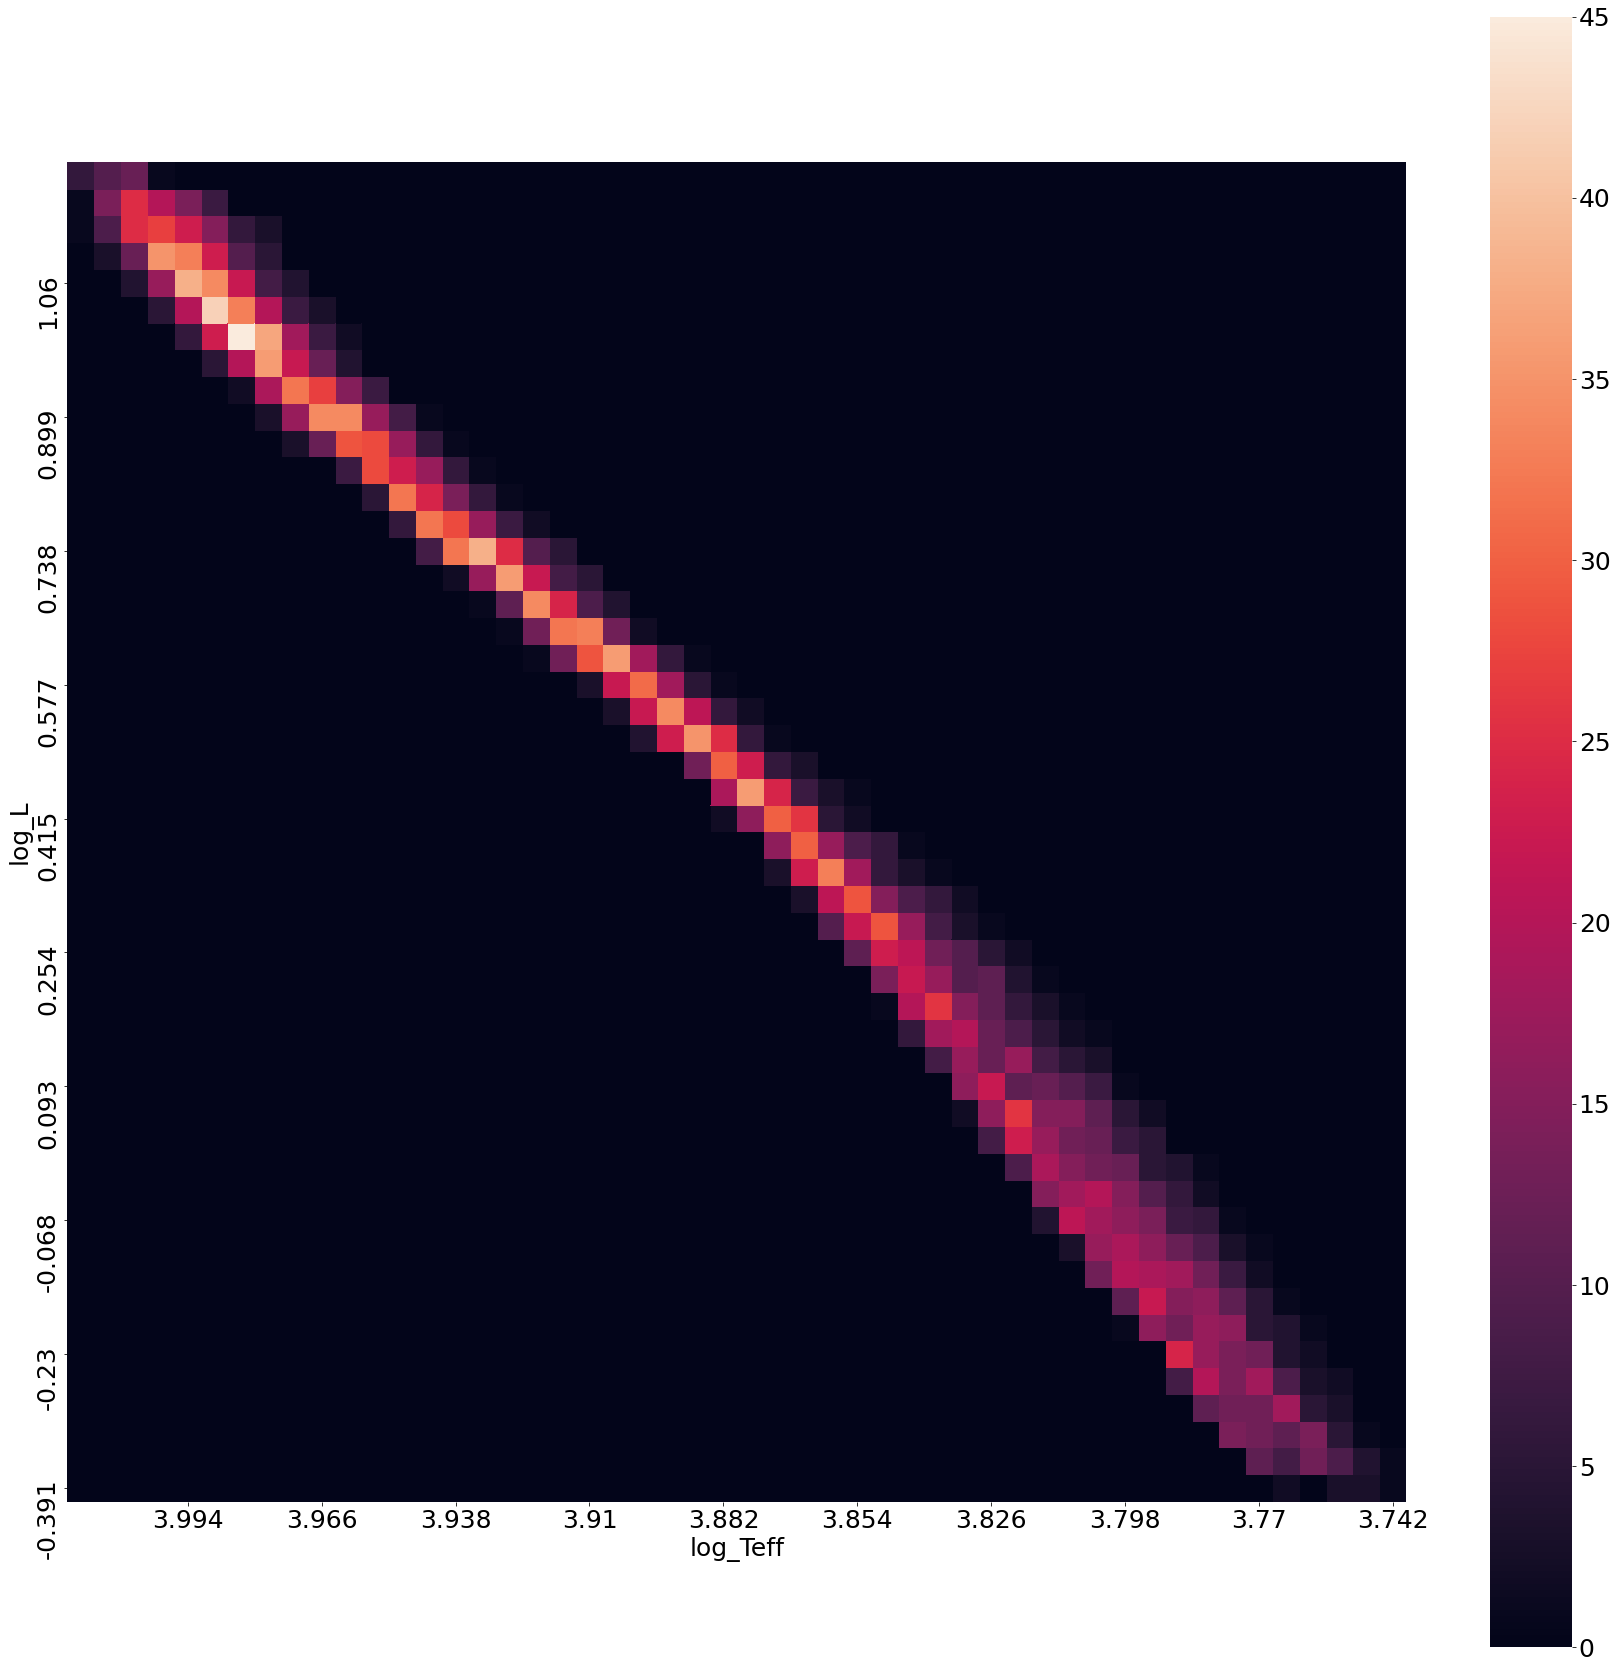

In [122]:
plt.matplotlib.rcParams['figure.figsize'] = (30,30)
plt.matplotlib.rcParams['font.size'] = 25

os.chdir('/home/zookeeper/Desktop/workdir/9.6/outiso')
x = np.array([])
y = np.array([])
for file in os.listdir():
    try:
        version, abun, rot, ages, num_ages, hdr_list, iso_set = read_iso_file(file)
        df = pd.DataFrame(iso_set[-11],columns = hdr_list)
        x = np.concatenate((x, df['log_Teff'].values))
        y = np.concatenate((y, df['log_L'].values))
    except:
        pass
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#plt.clf()
#plt.imshow(heatmap.T, extent=extent, origin='lower')
#plt.show()
xbin = 50
ybin = 50
xgrid=np.linspace(xedges[0], xedges[-1], xbin)
xminscale= (xedges[-1] - xedges[0])/xbin
ygrid=np.linspace(yedges[0], yedges[-1], ybin)
yminscale= (yedges[-1] - yedges[0])/ybin
globdata=np.zeros([xbin,ybin])
for file in os.listdir():
    try:
        version, abun, rot, ages, num_ages, hdr_list, iso_set = read_iso_file(file)
        df = pd.DataFrame(iso_set[-11],columns = hdr_list)
        locdata=np.zeros([xbin,ybin])
        for i in range(len(df)):
            xnum = int(np.floor((df['log_Teff'].values[i] - xedges[0])/xminscale))
            ynum = int(np.floor((df['log_L'].values[i] - yedges[0])/yminscale))
            if locdata[xnum, ynum] == 0:
                globdata[xnum, ynum] += 1
                locdata[xnum, ynum] += 1
    except:
        pass
final_data = np.zeros([xbin*ybin, 3])
for i in range(xbin):
    for j in range(ybin):
        final_data[xbin*i + j, 0] = round(xgrid[i],3)
        final_data[xbin*i + j, 1] = round(ygrid[j],3)
        final_data[xbin*i + j, 2] = globdata[i,j]
df_final = pd.DataFrame(data=final_data, columns = ['log_Teff', 'log_L', 'freq'])
df_final = df_final.pivot('log_L','log_Teff','freq')
ax = sns.heatmap(df_final,xticklabels=5,yticklabels=5, square=True)
ax.invert_yaxis()
ax.invert_xaxis()

In [21]:
df

,EEP,log10_isochrone_age_yr,initial_mass,star_mass,star_mdot,he_core_mass,c_core_mass,log_L,log_LH,log_LHe,...,surface_he3,surface_he4,surface_c12,surface_o16,log_center_T,log_center_Rho,center_gamma,center_h1,center_he4,center_c12
0,308,9.1,0.781879,0.781879,0.0,0.000000,0.0,-0.260664,-0.260210,-10.0,...,0.00003,0.237295,0.000080,0.000543,7.103425,2.036746,0.0,0.674346,0.324672,1.606183e-07
1,309,9.1,0.790939,0.790939,0.0,0.000000,0.0,-0.237323,-0.236869,-10.0,...,0.00003,0.237678,0.000080,0.000544,7.107521,2.039482,0.0,0.671431,0.327588,1.639523e-07
2,310,9.1,0.799968,0.799968,0.0,0.000000,0.0,-0.214018,-0.213565,-10.0,...,0.00003,0.238101,0.000080,0.000545,7.111625,2.042286,0.0,0.668410,0.330608,1.673654e-07
3,311,9.1,0.808938,0.808938,0.0,0.000000,0.0,-0.190821,-0.190368,-10.0,...,0.00003,0.238563,0.000080,0.000546,7.115726,2.045152,0.0,0.665285,0.333733,1.708814e-07
4,312,9.1,0.817850,0.817850,0.0,0.000000,0.0,-0.167729,-0.167275,-10.0,...,0.00003,0.239065,0.000080,0.000547,7.119825,2.048085,0.0,0.662051,0.336967,1.744627e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,427,9.1,1.487864,1.487864,0.0,0.000098,0.0,1.257962,1.258759,-10.0,...,0.00003,0.246158,0.000082,0.000562,7.408774,2.900010,0.0,0.000095,0.998935,2.784166e-06
116,428,9.1,1.490481,1.490481,0.0,0.000954,0.0,1.264114,1.264914,-10.0,...,0.00003,0.246158,0.000082,0.000562,7.409234,2.910401,0.0,0.000067,0.998963,2.789217e-06
117,429,9.1,1.493079,1.493079,0.0,0.002331,0.0,1.270276,1.271078,-10.0,...,0.00003,0.246158,0.000082,0.000562,7.409768,2.920856,0.0,0.000047,0.998984,2.794958e-06
118,430,9.1,1.495657,1.495657,0.0,0.003989,0.0,1.276448,1.277254,-10.0,...,0.00003,0.246158,0.000082,0.000562,7.410369,2.931397,0.0,0.000032,0.998998,2.801330e-06


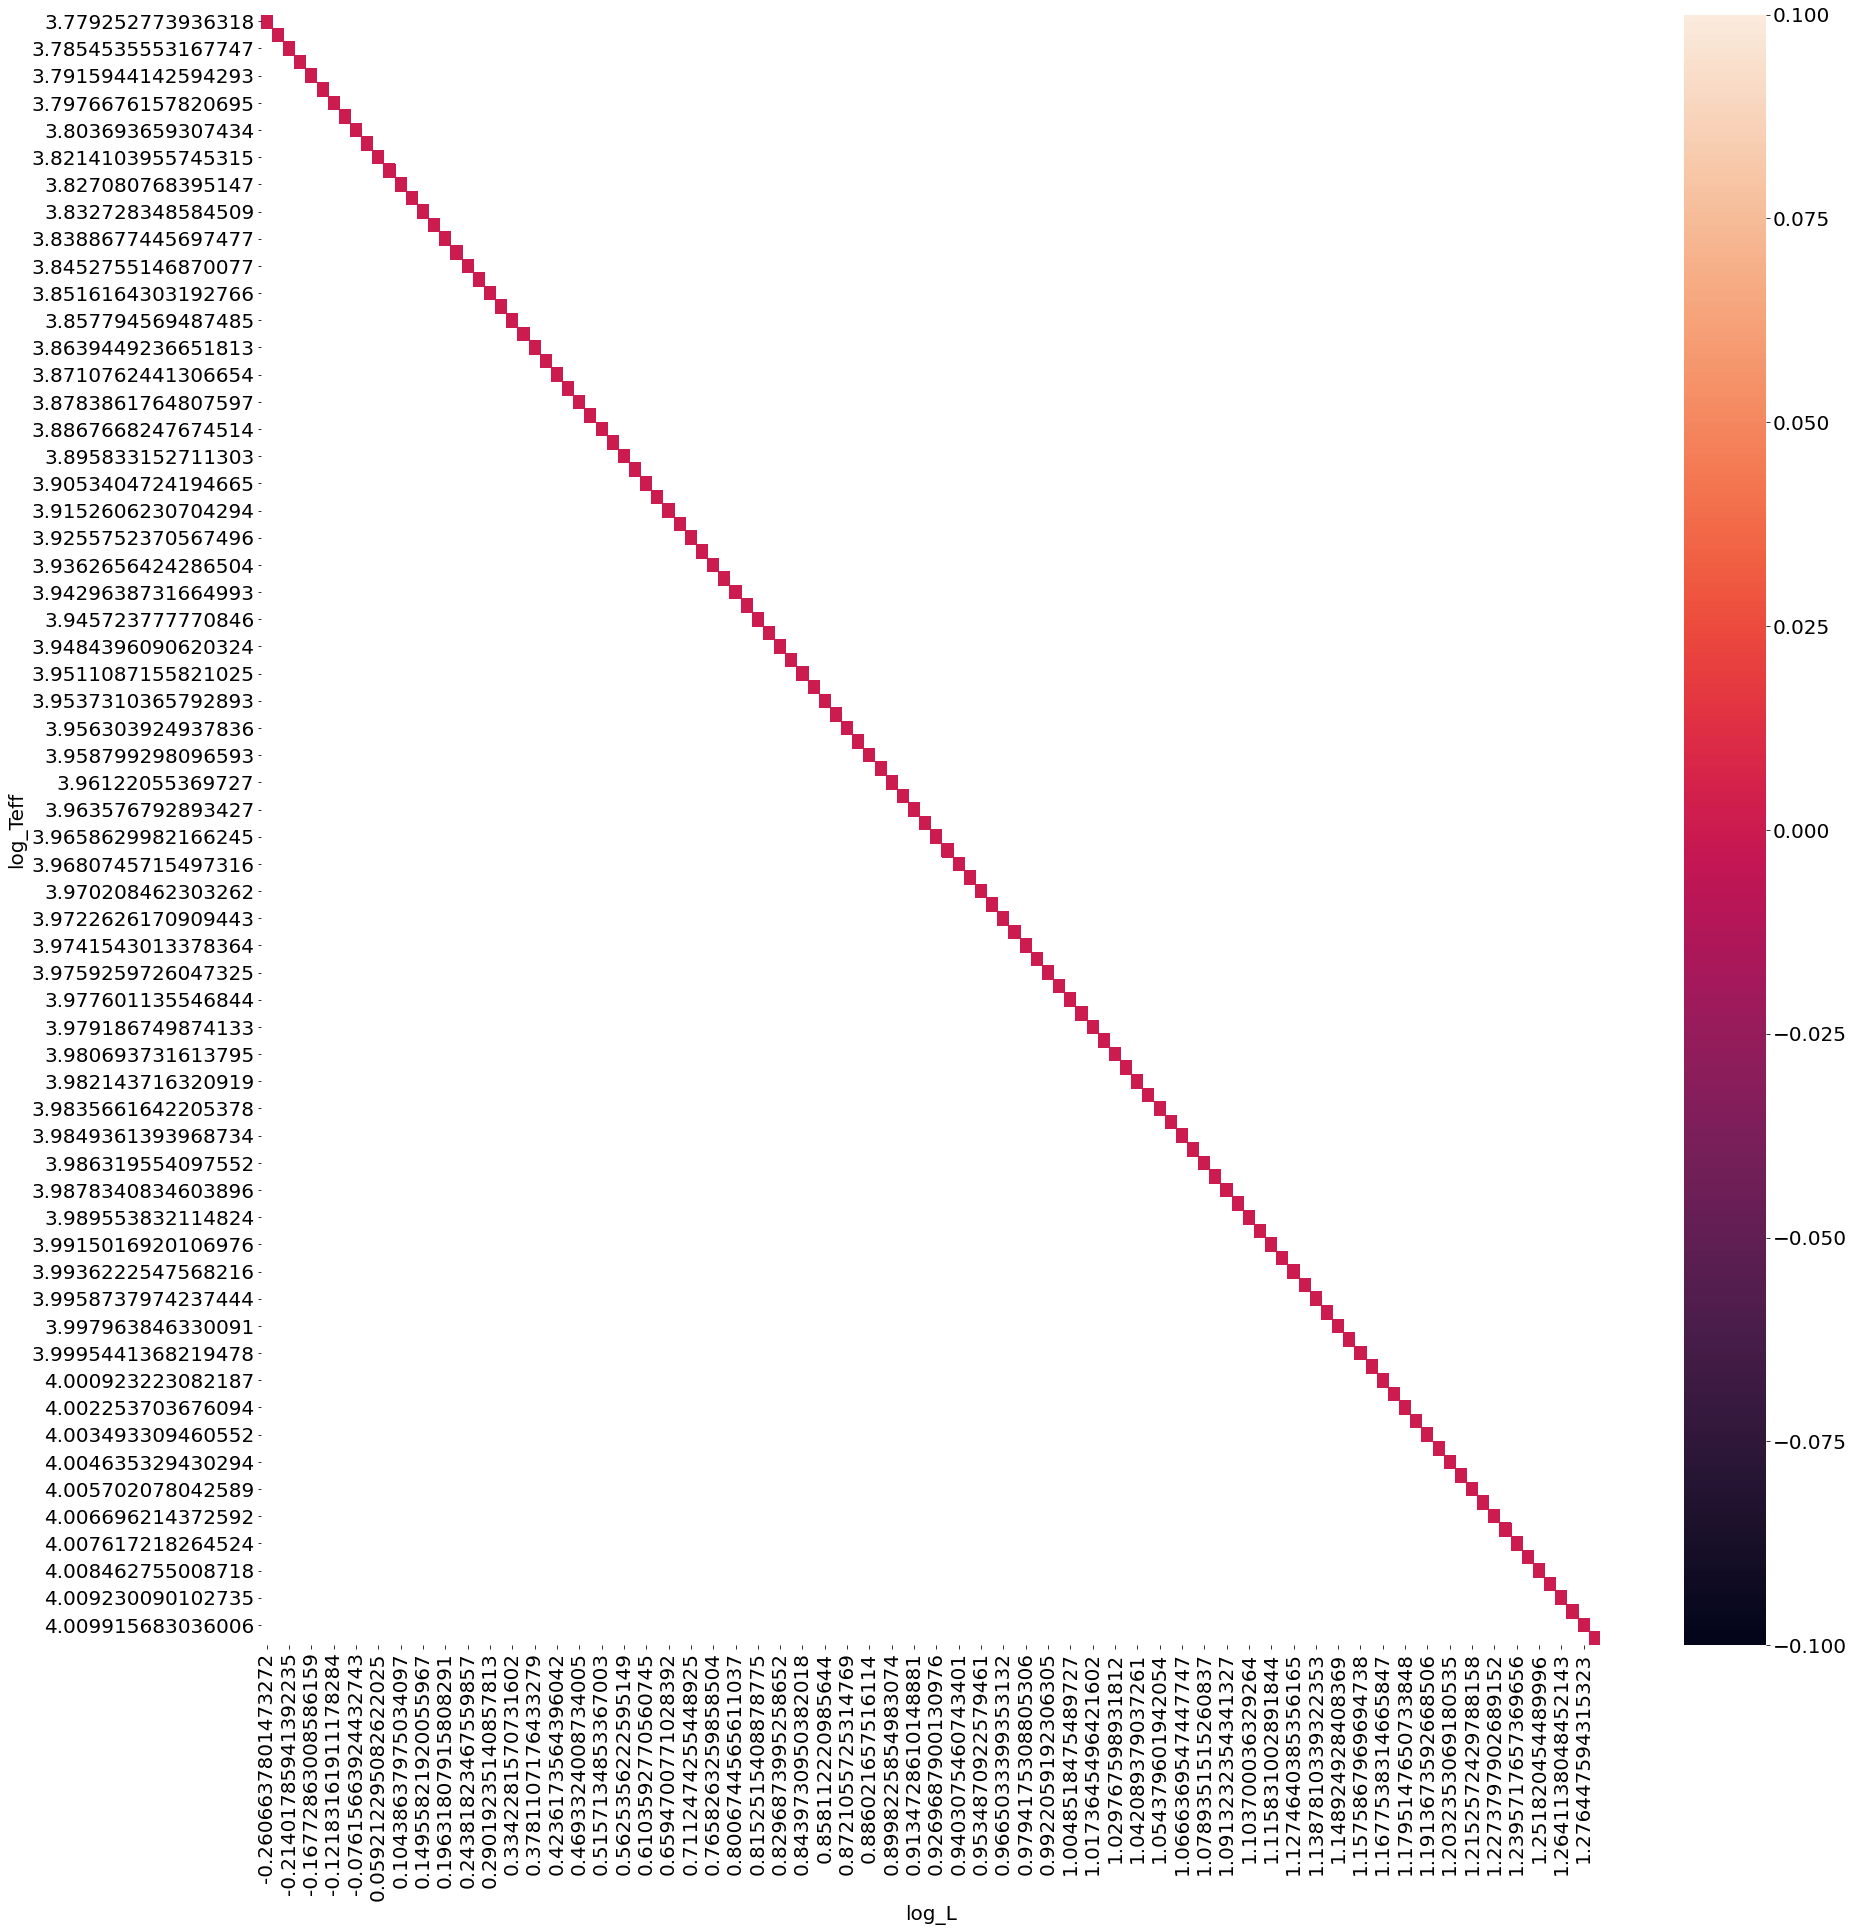

In [22]:
df = df.pivot("log_Teff", "log_L", "star_mdot")
ax = sns.heatmap(df)

In [24]:
df['log_Teff'].values

array([3.77925277, 3.78235714, 3.78545356, 3.78853253, 3.79159441,
       3.79463924, 3.79766762, 3.80068658, 3.80369366, 3.80668566,
       3.8214104 , 3.82425112, 3.82708077, 3.82990948, 3.83272835,
       3.83566151, 3.83886774, 3.84207482, 3.84527551, 3.84848304,
       3.85161643, 3.85470858, 3.85779457, 3.86087287, 3.86394492,
       3.86743767, 3.87107624, 3.87472502, 3.87838618, 3.88225278,
       3.88676682, 3.89129393, 3.89583315, 3.90038381, 3.90534047,
       3.91030621, 3.91526062, 3.92020853, 3.92557524, 3.93093029,
       3.93626564, 3.94156431, 3.94296387, 3.94435003, 3.94572378,
       3.94708753, 3.94843961, 3.94977954, 3.95110872, 3.95242619,
       3.95373104, 3.95502445, 3.95630392, 3.95756518, 3.9587993 ,
       3.96001792, 3.96122055, 3.96240745, 3.96357679, 3.96472887,
       3.965863  , 3.96697847, 3.96807457, 3.96915144, 3.97020846,
       3.97124678, 3.97226262, 3.97323282, 3.9741543 , 3.97505214,
       3.97592597, 3.97677543, 3.97760114, 3.97840554, 3.97918

In [42]:
int(np.floor(1.2))

1

In [43]:
xbin = 50
ybin = 50
xgrid=np.linspace(xedges[0], xedges[-1], xbin)
xminscale= (xedges[-1] - xedges[0])/xbin
ygrid=np.linspace(yedges[0], yedges[-1], ybin)

In [44]:
xgrid

array([3.75599654, 3.76136286, 3.76672918, 3.7720955 , 3.77746182,
       3.78282815, 3.78819447, 3.79356079, 3.79892711, 3.80429343,
       3.80965975, 3.81502607, 3.82039239, 3.82575871, 3.83112503,
       3.83649135, 3.84185767, 3.84722399, 3.85259031, 3.85795663,
       3.86332295, 3.86868927, 3.87405559, 3.87942191, 3.88478824,
       3.89015456, 3.89552088, 3.9008872 , 3.90625352, 3.91161984,
       3.91698616, 3.92235248, 3.9277188 , 3.93308512, 3.93845144,
       3.94381776, 3.94918408, 3.9545504 , 3.95991672, 3.96528304,
       3.97064936, 3.97601568, 3.981382  , 3.98674832, 3.99211465,
       3.99748097, 4.00284729, 4.00821361, 4.01357993, 4.01894625])

In [51]:
xy, yx = np.meshgrid(x, y)

In [53]:
xy[0]

array([3.77925277, 3.78235714, 3.78545356, ..., 4.00320152, 4.00347482,
       4.003729  ])

array([-0.98511431, -0.897639  , -0.81015467, ...,  5.06210678,
        5.08688614,  5.11168594])

In [56]:
final_data = np.zeros([xbin, ybin, 3])
final_data

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [115]:
ages[-1]

10.0

In [121]:
ages[-11]

9.0

In [ ]:
plt.matplotlib.rcParams['figure.figsize'] = (30,30)
plt.matplotlib.rcParams['font.size'] = 25

os.chdir('/home/zookeeper/Desktop/workdir/9.6/outiso')
x = np.array([])
y = np.array([])
for file in os.listdir():
    try:
        version, abun, rot, ages, num_ages, hdr_list, iso_set = read_iso_file(file)
        df = pd.DataFrame(iso_set[-1],columns = hdr_list)
        x = np.concatenate((x, df['log_Teff'].values))
        y = np.concatenate((y, df['log_L'].values))
    except:
        pass
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#plt.clf()
#plt.imshow(heatmap.T, extent=extent, origin='lower')
#plt.show()
xbin = 50
ybin = 50
xgrid=np.linspace(xedges[0], xedges[-1], xbin)
xminscale= (xedges[-1] - xedges[0])/xbin
ygrid=np.linspace(yedges[0], yedges[-1], ybin)
yminscale= (yedges[-1] - yedges[0])/ybin
globdata=np.zeros([xbin,ybin])
for file in os.listdir():
    try:
        version, abun, rot, ages, num_ages, hdr_list, iso_set = read_iso_file(file)
        df = pd.DataFrame(iso_set[-1],columns = hdr_list)
        locdata=np.zeros([xbin,ybin])
        for i in range(len(df)):
            xnum = int(np.floor((df['log_Teff'].values[i] - xedges[0])/xminscale))
            ynum = int(np.floor((df['log_L'].values[i] - yedges[0])/yminscale))
            if locdata[xnum, ynum] == 0:
                globdata[xnum, ynum] += 1
                locdata[xnum, ynum] += 1
    except:
        pass
final_data = np.zeros([xbin*ybin, 3])
for i in range(xbin):
    for j in range(ybin):
        final_data[xbin*i + j, 0] = round(xgrid[i],3)
        final_data[xbin*i + j, 1] = round(ygrid[j],3)
        final_data[xbin*i + j, 2] = globdata[i,j]
df_final = pd.DataFrame(data=final_data, columns = ['log_Teff', 'log_L', 'freq'])
df_final = df_final.pivot('log_L','log_Teff','freq')
ax = sns.heatmap(df_final,xticklabels=5,yticklabels=5, square=True)
ax.invert_yaxis()
ax.invert_xaxis()

In [144]:
plt.matplotlib.rcParams['figure.figsize'] = (30,30)
plt.matplotlib.rcParams['font.size'] = 25

set_num = 5
os.chdir('/home/zookeeper/Desktop/workdir/9.20/outiso')
x = np.array([])
y = np.array([])
for file in os.listdir():
    try:
        version, abun, rot, ages, num_ages, hdr_list, iso_set = read_iso_file(file)
        df = pd.DataFrame(iso_set[set_num],columns = hdr_list)
        if len(df['log_Teff']) > 100 and len(df['log_L']) > 100:
            x = np.concatenate((x, df['log_Teff'].values))
            y = np.concatenate((y, df['log_L'].values))
    except:
        pass
xmax = max(x)
xmin = min(x)
ymax = max(y) - 0.1
ymin = min(y) + 0.1
grid_num = 50
ygrid = np.linspace(ymin,ymax,grid_num)
xgrid = [None]*grid_num
for i in np.arange(len(xgrid)):
    xgrid[i] = []
for file in os.listdir():
    try:
        version, abun, rot, ages, num_ages, hdr_list, iso_set = read_iso_file(file)
        df = pd.DataFrame(iso_set[set_num],columns = hdr_list)
        if len(df['log_Teff']) > 100 and len(df['log_L']) > 100:
            x = df['log_Teff'].values
            y = df['log_L'].values
            for i in np.arange(len(ygrid)):
                closestj = -1
                min_dist = np.inf
                for j in np.arange(len(y)):
                    if np.abs(y[j] - ygrid[i]) < min_dist:
                        min_dist = np.abs(y[j] - ygrid[i])
                        closestj = j
                if closestj != -1 and min_dist < 0.1:
                    xgrid[i].append(x[closestj])
    except:
        pass
xgridmean = np.zeros(grid_num)
xgridmedian = np.zeros(grid_num)
xgrid5 = np.zeros(grid_num)
xgrid95 = np.zeros(grid_num)
xgrid32 = np.zeros(grid_num)
xgrid68 = np.zeros(grid_num)
for i in np.arange(len(xgrid)):
    leni = len(xgrid[i])
    xgrid[i].sort()
    xgridmean[i] = np.mean(xgrid[i])
    xgridmedian[i] = xgrid[i][int(leni/2)]
    xgrid5[i] = xgrid[i][int(leni*0.05)]
    xgrid95[i] = xgrid[i][int(leni*0.95)]
    xgrid32[i] = xgrid[i][int(leni*0.32)]
    xgrid68[i] = xgrid[i][int(leni*0.68)]

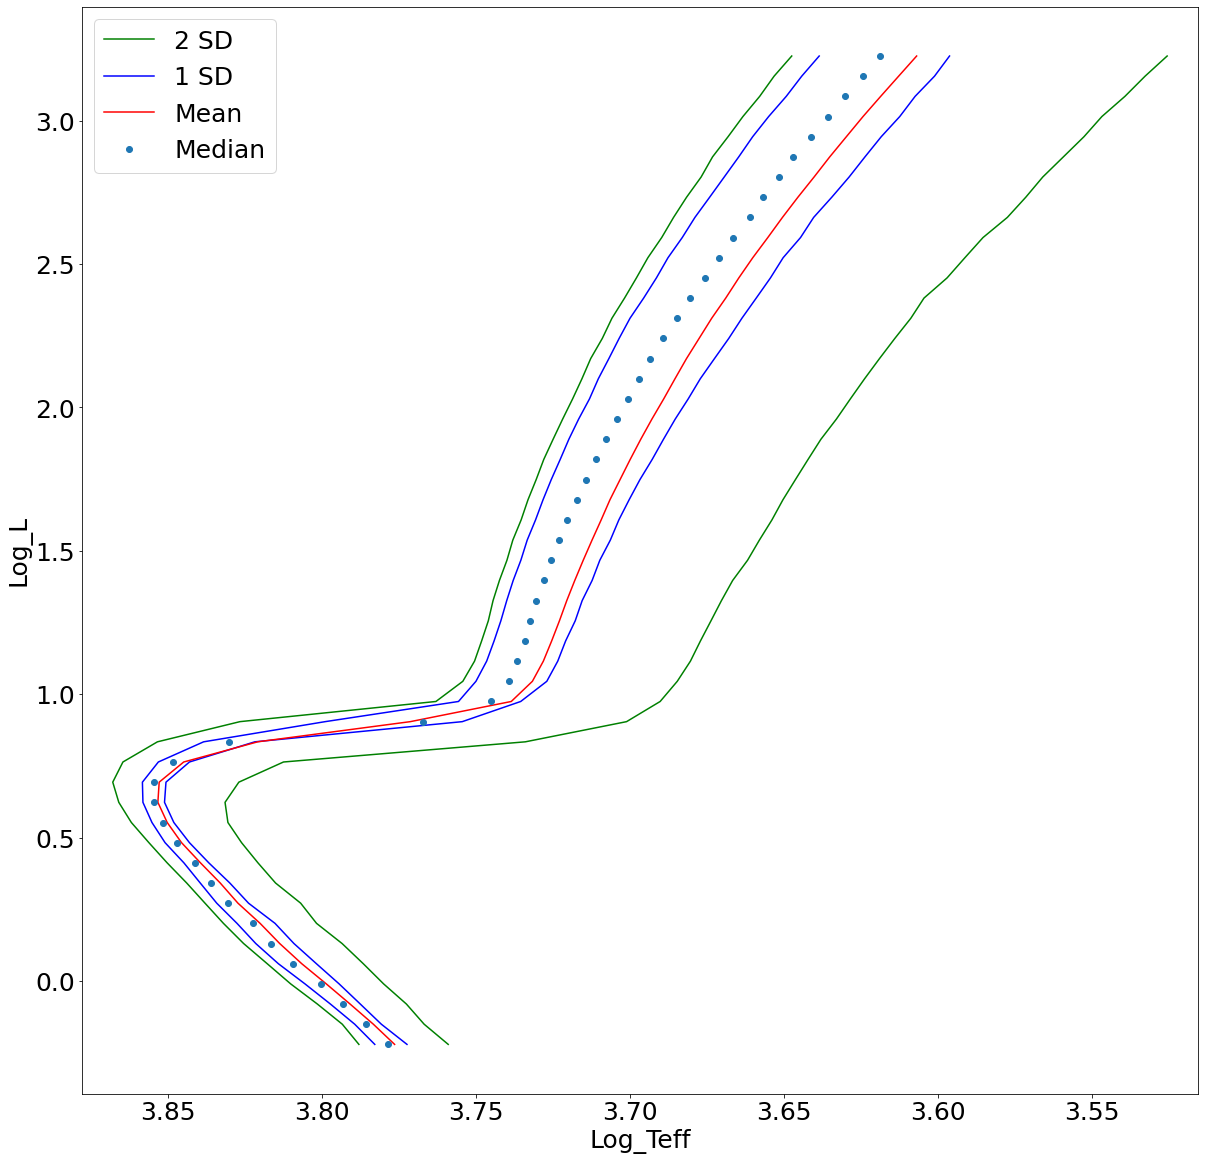

In [145]:
plt.matplotlib.rcParams['figure.figsize'] = (20,20)
plt.matplotlib.rcParams['font.size'] = 25
xmin = min(xgrid5) - 0.01
xmax = max(xgrid95) + 0.01
plt.plot(xgrid5,ygrid,'g',label='2 SD')
plt.plot(xgrid95,ygrid,'g')
plt.plot(xgrid32,ygrid,'b',label='1 SD')
plt.plot(xgrid68,ygrid,'b')
plt.plot(xgridmean,ygrid,'r',label='Mean')
plt.plot(xgridmedian,ygrid,'o',label='Median')
plt.xlim(xmax,xmin)
plt.xlabel('Log_Teff')
plt.ylabel('Log_L')
plt.legend();

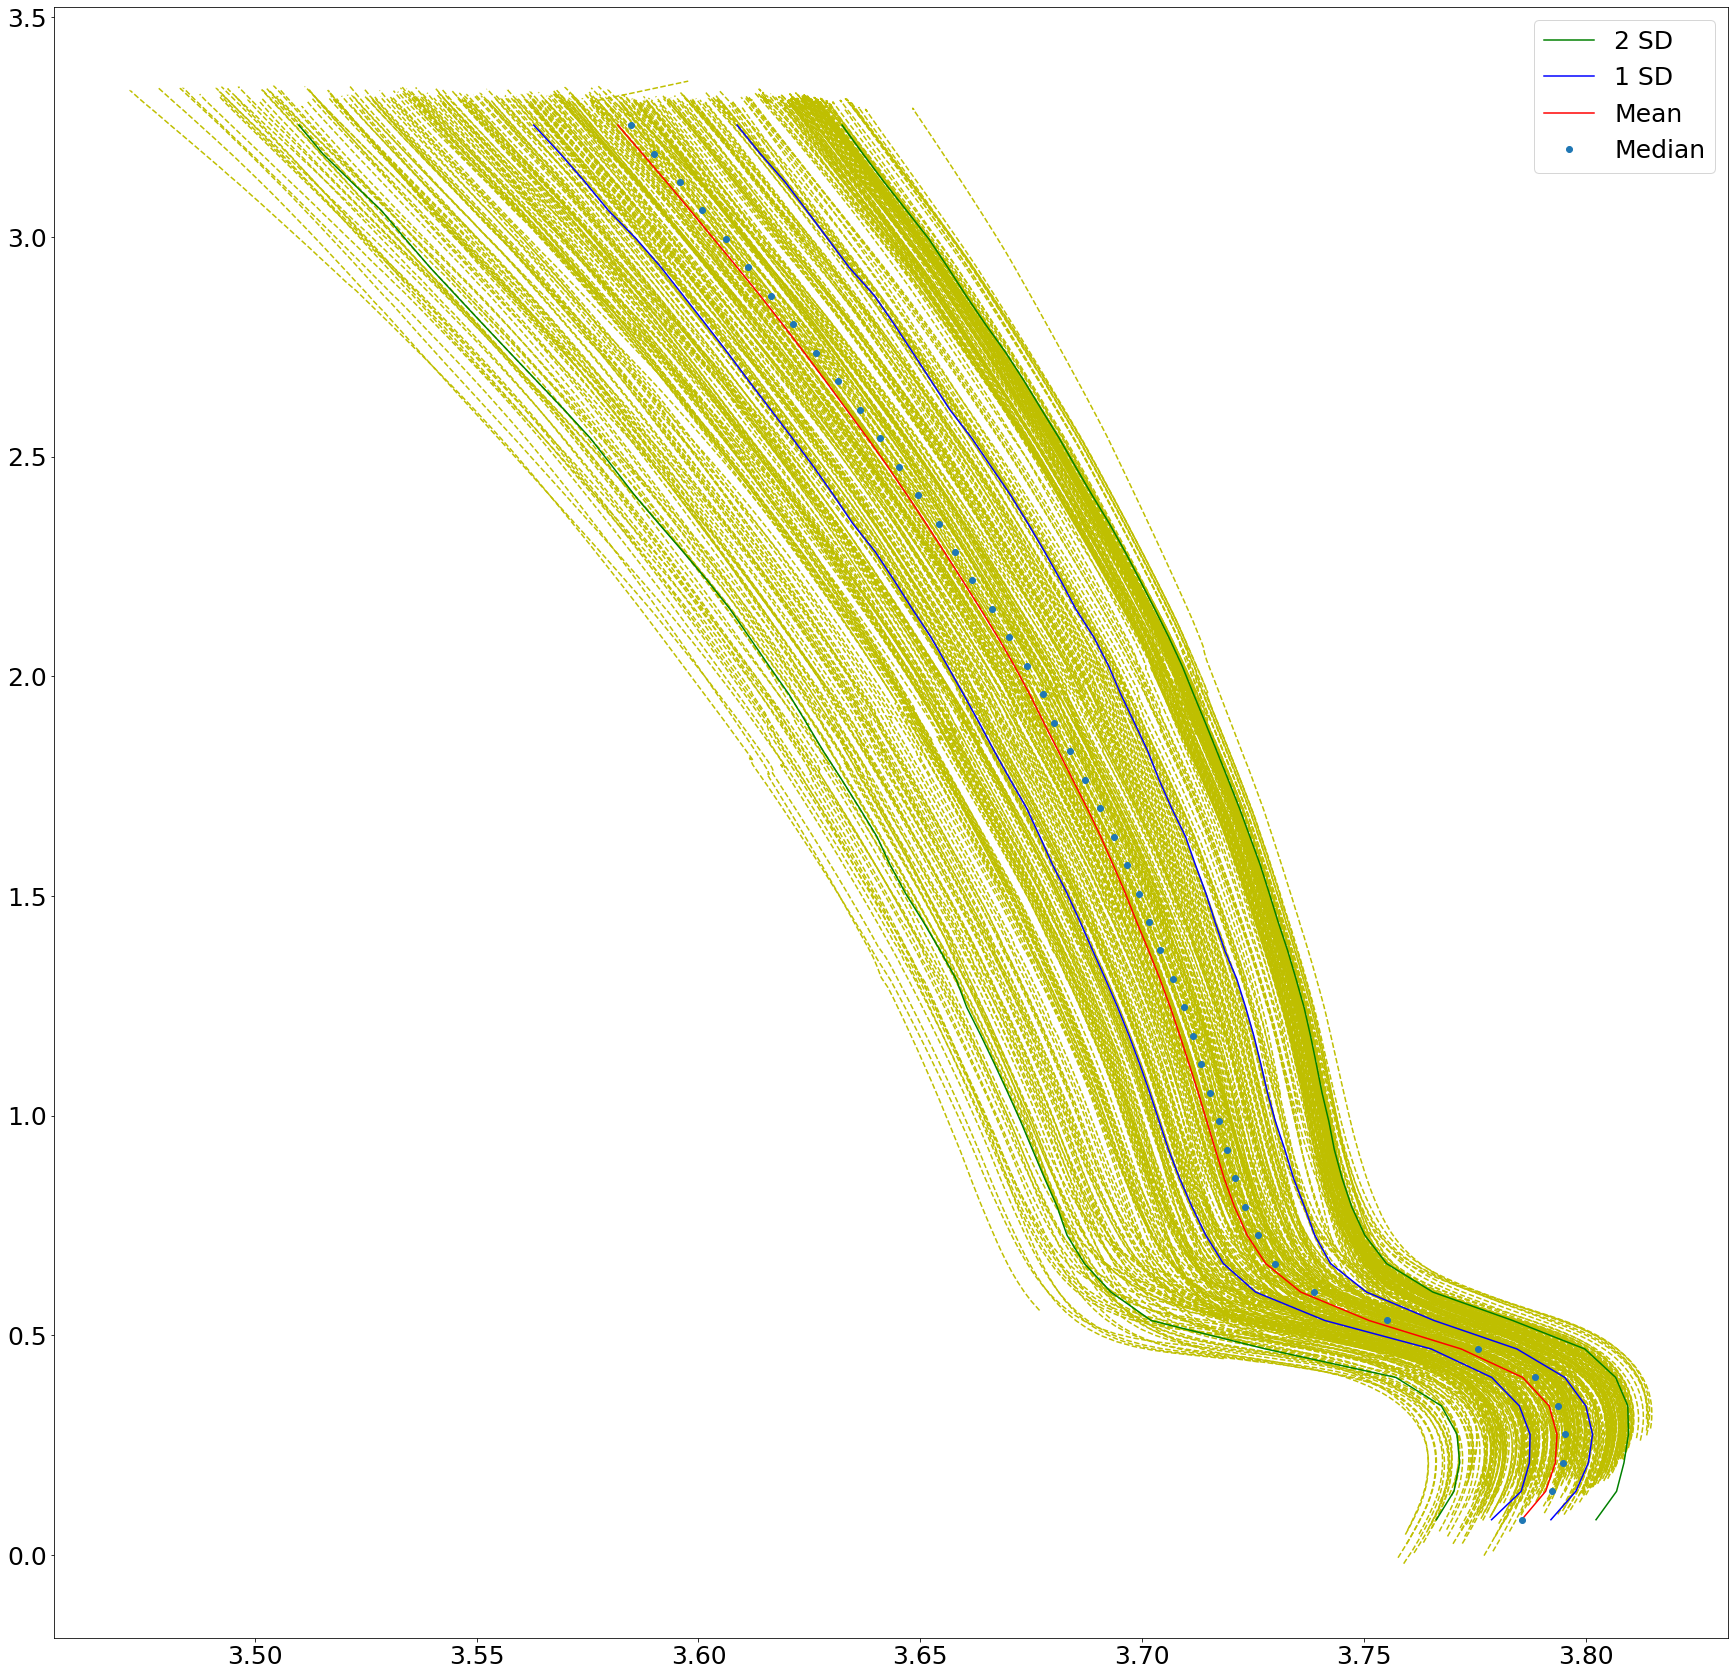

In [116]:
count = 0
for file in os.listdir():
    try:
        version, abun, rot, ages, num_ages, hdr_list, iso_set = read_iso_file(file)
        df = pd.DataFrame(iso_set[set_num],columns = hdr_list)
        if len(df['log_Teff']) > 100 and len(df['log_L']) > 100:
            plt.plot(df['log_Teff'],df['log_L'],'y--')
            count += 1
    except:
        pass
plt.plot(xgrid5,ygrid,'g',label='2 SD')
plt.plot(xgrid95,ygrid,'g')
plt.plot(xgrid32,ygrid,'b',label='1 SD')
plt.plot(xgrid68,ygrid,'b')
plt.plot(xgridmean,ygrid,'r',label='Mean')
plt.plot(xgridmedian,ygrid,'o',label='Median')
plt.legend();

In [117]:
count

365

In [108]:
xgrid[0]

[3.748496465855444,
 3.7503616835101306,
 3.7503867109577778,
 3.7504331206648343,
 3.750603125985926,
 3.750894392191246,
 3.7530554159925535,
 3.7540220942068756,
 3.7549344669871974,
 3.7561390194099054,
 3.7568653536492693,
 3.7579038943156524,
 3.75821968532604,
 3.7593093564396396,
 3.759636498685302,
 3.759817956486248,
 3.759866187272981,
 3.760444699591553,
 3.760929990741909,
 3.7610440564767775,
 3.762542435280749,
 3.762585824698661,
 3.7629942257935953,
 3.763108273269497,
 3.7636875686170113,
 3.7640336635733127,
 3.7641996446542505,
 3.7646509234625474,
 3.7647037297356367,
 3.7649995282977753,
 3.76506738079644,
 3.766033243705659,
 3.766045877107487,
 3.7662390229234717,
 3.7663294719598053,
 3.766542904185791,
 3.766690208467503,
 3.7668539831993053,
 3.76697139862403,
 3.7670176567632065,
 3.767148212348976,
 3.767439044631987,
 3.7674766840438543,
 3.7676829078432292,
 3.7680388131987534,
 3.768103942028632,
 3.7682943455958755,
 3.7683108234400953,
 3.7691735880255

In [74]:
df['log_Teff']

0      3.806503
1      3.806868
2      3.807181
3      3.807444
4      3.807658
         ...   
193    3.620657
194    3.620702
195    3.620745
196    3.620773
197    3.620710
Name: log_Teff, Length: 198, dtype: float64

In [76]:
df['log_L']

0      0.222318
1      0.233920
2      0.245448
3      0.256819
4      0.268054
         ...   
193    3.302293
194    3.302334
195    3.302323
196    3.302183
197    3.301691
Name: log_L, Length: 198, dtype: float64

In [54]:
xgrid[0]

[3.774178284383252,
 3.774413061036876,
 3.7751180021711064,
 3.7751952632572037,
 3.7766797123592006,
 3.776945404800995,
 3.7769962402750794,
 3.777946750701603,
 3.778204790889247,
 3.778457829750157,
 3.7784838166545534,
 3.778489795630623,
 3.7788196195659474,
 3.7791572444947157,
 3.779233694776956,
 3.779281798387782,
 3.779288483471304,
 3.779489684005757,
 3.7798887793215634,
 3.780225603540735,
 3.7814634274908165,
 3.7815562961897733,
 3.7817831050129063,
 3.7819215065013405,
 3.781953436529109,
 3.7822547911961717,
 3.7828291825377103,
 3.782905377480363,
 3.783080178347109,
 3.7831320079158197,
 3.783132069077128,
 3.784258219515844,
 3.7843602571676733,
 3.7843834787377633,
 3.784636449517593,
 3.7846802963585837,
 3.7847129531870567,
 3.785190272557057,
 3.7852106690326863,
 3.7852185549450352,
 3.785360639766234,
 3.7854303127317417,
 3.785463267807433,
 3.7854865600247116,
 3.7858873013824383,
 3.7859314893463285,
 3.7859685453465595,
 3.7859768668583413,
 3.7860297951

In [72]:
df

,EEP,isochrone_age_yr,initial_mass,star_mass,star_mdot,he_core_mass,c_core_mass,log_L,log_LH,log_LHe,...,surface_he3,surface_he4,surface_c12,surface_o16,log_center_T,log_center_Rho,center_gamma,center_h1,center_he4,center_c12
0,434,1.400000e+10,0.750737,0.750737,0.0,0.000000,0.0,0.222318,0.222780,-10.000000,...,0.000030,0.185406,0.000053,0.000361,7.340358,3.110124,0.0,0.003530,0.995544,0.000002
1,435,1.400000e+10,0.751999,0.751999,0.0,0.000000,0.0,0.233920,0.234387,-10.000000,...,0.000030,0.186420,0.000053,0.000362,7.342097,3.132427,0.0,0.002211,0.996863,0.000002
2,436,1.400000e+10,0.753217,0.753217,0.0,0.000000,0.0,0.245448,0.245918,-10.000000,...,0.000030,0.187398,0.000053,0.000364,7.343471,3.155506,0.0,0.001335,0.997740,0.000002
3,437,1.400000e+10,0.754385,0.754385,0.0,0.000000,0.0,0.256819,0.257290,-10.000000,...,0.000030,0.188336,0.000054,0.000366,7.344304,3.179715,0.0,0.000771,0.998303,0.000002
4,438,1.400000e+10,0.755511,0.755511,0.0,0.000000,0.0,0.268054,0.268533,-10.000000,...,0.000030,0.189240,0.000054,0.000367,7.344756,3.204810,0.0,0.000428,0.998647,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,627,1.400000e+10,0.784779,0.784779,0.0,0.493102,0.0,3.302293,3.304523,3.506049,...,0.001691,0.243863,0.000064,0.000444,7.871219,6.047898,0.0,0.000000,0.999064,0.000027
194,628,1.400000e+10,0.784779,0.784779,0.0,0.493097,0.0,3.302334,3.307702,3.543252,...,0.001691,0.243863,0.000064,0.000444,7.871037,6.047630,0.0,0.000000,0.999064,0.000027
195,629,1.400000e+10,0.784779,0.784779,0.0,0.493106,0.0,3.302323,3.301816,3.570430,...,0.001691,0.243863,0.000064,0.000444,7.870925,6.047390,0.0,0.000000,0.999064,0.000027
196,630,1.400000e+10,0.784779,0.784779,0.0,0.493093,0.0,3.302183,3.303252,3.614661,...,0.001691,0.243863,0.000064,0.000444,7.870734,6.047021,0.0,0.000000,0.999064,0.000027


In [109]:
np.abs(-1)

1

In [80]:
x[closestj]

3.806502671121757

In [86]:
y

array([0.22231765, 0.23392027, 0.24544776, 0.25681857, 0.26805394,
       0.27928417, 0.29047865, 0.30159713, 0.3126274 , 0.32355933,
       0.33437761, 0.34506762, 0.35561553, 0.36600126, 0.37620935,
       0.38623402, 0.39606573, 0.40569645, 0.41509391, 0.42428223,
       0.43322885, 0.44719162, 0.46048571, 0.47306697, 0.48473244,
       0.4956662 , 0.50619555, 0.5163857 , 0.5262523 , 0.53633092,
       0.54644908, 0.55650935, 0.56662944, 0.5771366 , 0.58833716,
       0.60039744, 0.61357256, 0.62792192, 0.64341181, 0.65996285,
       0.6773769 , 0.69546706, 0.71409869, 0.73314694, 0.75251407,
       0.77211427, 0.79191148, 0.81186621, 0.83195854, 0.85215838,
       0.87245642, 0.89283566, 0.91329136, 0.93380967, 0.95438913,
       0.97501163, 0.99567901, 1.01637566, 1.03709503, 1.05784238,
       1.07861239, 1.09940438, 1.12021508, 1.14105689, 1.16190626,
       1.18276474, 1.20362826, 1.22448706, 1.2453401 , 1.26619504,
       1.28705209, 1.3079067 , 1.32875785, 1.34961021, 1.37045

In [137]:
plt.matplotlib.rcParams['figure.figsize'] = (30,30)
plt.matplotlib.rcParams['font.size'] = 25

set_num = 0
os.chdir('/home/zookeeper/Desktop/workdir/9.20/outiso')
x = np.array([])
y = np.array([])
for file in os.listdir():
    try:
        version, abun, rot, ages, num_ages, hdr_list, iso_set = read_iso_file(file)
        df = pd.DataFrame(iso_set[set_num],columns = hdr_list)
        if len(df['log_Teff']) > 100 and len(df['log_L']) > 100:
            x = np.concatenate((x, df['log_Teff'].values))
            y = np.concatenate((y, df['log_L'].values))
    except:
        pass

In [127]:
x

array([3.80418071, 3.80449683, 3.80475785, ..., 3.62074474, 3.6207727 ,
       3.62071021])

In [129]:
d = {'Log_Teff': x, 'Log_L': y}
df = pd.DataFrame(data=d)

In [131]:
df

,Log_Teff,Log_L
0,3.804181,0.231229
1,3.804497,0.242800
2,3.804758,0.254298
3,3.804971,0.265644
4,3.805132,0.276862
...,...,...
70546,3.620657,3.302293
70547,3.620702,3.302334
70548,3.620745,3.302323
70549,3.620773,3.302183


In [134]:
df.to_csv('/home/zookeeper/Desktop/1.4Gyr_iso.csv')

In [156]:
plt.matplotlib.rcParams['figure.figsize'] = (30,30)
plt.matplotlib.rcParams['font.size'] = 25

set_num = -1
os.chdir('/home/zookeeper/Desktop/workdir/9.23/outiso')
x = np.array([])
y = np.array([])
for file in os.listdir():
    try:
        version, abun, rot, ages, num_ages, hdr_list, iso_set = read_iso_file(file)
        df = pd.DataFrame(iso_set[set_num],columns = hdr_list)
        if len(df['log_Teff']) > 100 and len(df['log_L']) > 100:
            x = np.concatenate((x, df['log_Teff'].values))
            y = np.concatenate((y, df['log_L'].values))
    except:
        pass
xmax = max(x)
xmin = min(x)
ymax = max(y) - 0.1
ymin = min(y) + 0.1
grid_num = 50
ygrid = np.linspace(ymin,ymax,grid_num)
xgrid = [None]*grid_num
for i in np.arange(len(xgrid)):
    xgrid[i] = []
for file in os.listdir():
    try:
        version, abun, rot, ages, num_ages, hdr_list, iso_set = read_iso_file(file)
        df = pd.DataFrame(iso_set[set_num],columns = hdr_list)
        if len(df['log_Teff']) > 100 and len(df['log_L']) > 100:
            x = df['log_Teff'].values
            y = df['log_L'].values
            for i in np.arange(len(ygrid)):
                closestj = -1
                min_dist = np.inf
                for j in np.arange(len(y)):
                    if np.abs(y[j] - ygrid[i]) < min_dist:
                        min_dist = np.abs(y[j] - ygrid[i])
                        closestj = j
                if closestj != -1 and min_dist < 0.1:
                    xgrid[i].append(x[closestj])
    except:
        pass
xgridmean = np.zeros(grid_num)
xgridmedian = np.zeros(grid_num)
xgrid5 = np.zeros(grid_num)
xgrid95 = np.zeros(grid_num)
xgrid32 = np.zeros(grid_num)
xgrid68 = np.zeros(grid_num)
for i in np.arange(len(xgrid)):
    leni = len(xgrid[i])
    xgrid[i].sort()
    xgridmean[i] = np.mean(xgrid[i])
    xgridmedian[i] = xgrid[i][int(leni/2)]
    xgrid5[i] = xgrid[i][int(leni*0.05)]
    xgrid95[i] = xgrid[i][int(leni*0.95)]
    xgrid32[i] = xgrid[i][int(leni*0.32)]
    xgrid68[i] = xgrid[i][int(leni*0.68)]

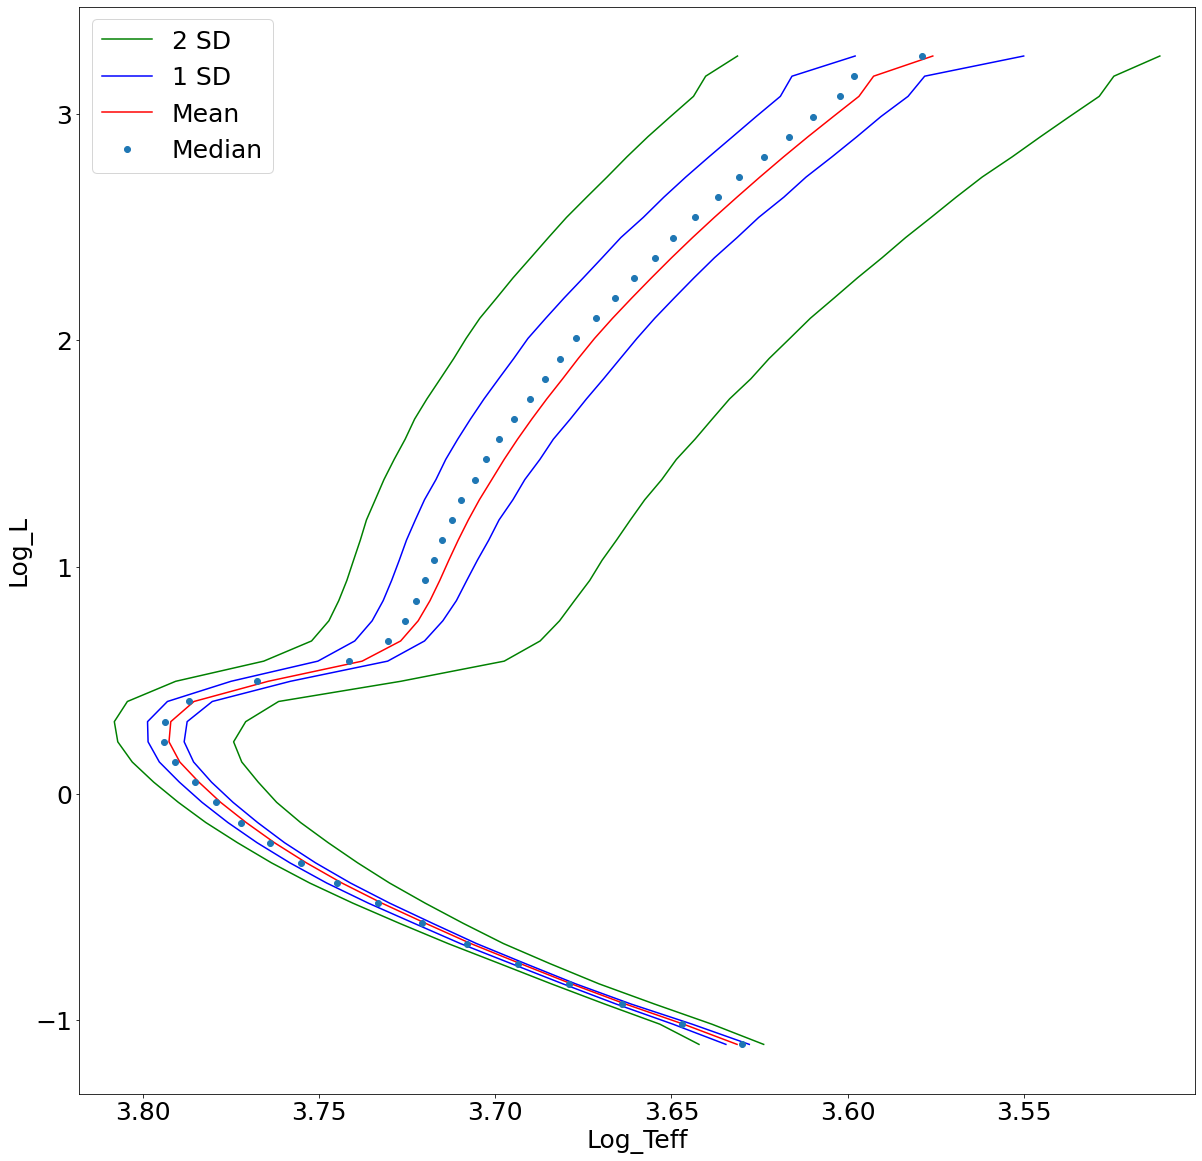

In [157]:
plt.matplotlib.rcParams['figure.figsize'] = (20,20)
plt.matplotlib.rcParams['font.size'] = 25
xmin = min(xgrid5) - 0.01
xmax = max(xgrid95) + 0.01
plt.plot(xgrid5,ygrid,'g',label='2 SD')
plt.plot(xgrid95,ygrid,'g')
plt.plot(xgrid32,ygrid,'b',label='1 SD')
plt.plot(xgrid68,ygrid,'b')
plt.plot(xgridmean,ygrid,'r',label='Mean')
plt.plot(xgridmedian,ygrid,'o',label='Median')
plt.xlim(xmax,xmin)
plt.xlabel('Log_Teff')
plt.ylabel('Log_L')
plt.legend();